# Residual Network_Fashion-MNIST

## Residual network

In [1]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, BatchNormalization, Conv2D, Dense, Flatten, Add
import numpy as np
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt



#### The Fashion-MNIST dataset
The [Fashion-MNIST dataset](https://github.com/zalandoresearch/fashion-mnist). It consists of a training set of 60,000 images of fashion items with corresponding labels, and a test set of 10,000 images. The images have been normalised and centred. The dataset is frequently used in machine learning research, especially as a drop-in replacement for the MNIST dataset.

- H. Xiao, K. Rasul, and R. Vollgraf. "Fashion-MNIST: a Novel Image Dataset for Benchmarking Machine Learning Algorithms." arXiv:1708.07747, August 2017.

Goal is to construct a ResNet model that classifies images of fashion items into one of 10 classes.

#### Load the dataset

For this programming assignment, we will take a smaller sample of the dataset to reduce the training time.

In [2]:
# Load and preprocess the Fashion-MNIST dataset

(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

train_images = train_images.astype(np.float32)
test_images = test_images.astype(np.float32)

train_images = train_images[:5000] / 255.
train_labels = train_labels[:5000]

test_images = test_images / 255.

train_images = train_images[..., np.newaxis]
test_images = test_images[..., np.newaxis]

4422102/4422102 [==============================] - 0s 0us/step


In [3]:
# Create Dataset objects for the training and test sets

train_dataset = tf.data.Dataset.from_tensor_slices((train_images, train_labels))
train_dataset = train_dataset.batch(32)

test_dataset = tf.data.Dataset.from_tensor_slices((test_images, test_labels))
test_dataset = test_dataset.batch(32)

In [4]:
# Get dataset labels

image_labels = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

#### Create custom layers for the residual blocks

In [5]:
class ResidualBlock(Layer):

    def __init__(self, **kwargs):
        super(ResidualBlock, self).__init__(**kwargs)

    def build(self, input_shape):
        """
        This method should build the layers according to the above specification. Make sure
        to use the input_shape argument to get the correct number of filters, and to set the
        input_shape of the first layer in the block.
        """
        self.batch_norm_1 = BatchNormalization(input_shape=input_shape)
        self.conv2d_1 = Conv2D(input_shape[-1],(3,3),padding="SAME")
        self.batch_norm_2 = BatchNormalization()
        self.conv2d_2 = Conv2D(input_shape[-1],(3,3),padding="SAME")

    def call(self, inputs, training=False):
        """
        This method should contain the code for calling the layer according to the above
        specification, using the layer objects set up in the build method.
        """
        x = self.batch_norm_1(inputs, training=training)
        x = tf.nn.relu(x)
        x = self.conv2d_1(x)
        x = self.batch_norm_2(x, training=training)
        x = tf.nn.relu(x)
        x = self.conv2d_2(x)
        x = Add()([inputs, x])
        return x



In [6]:
# Test the custom layer

test_model = tf.keras.Sequential([ResidualBlock(input_shape=(28, 28, 1), name="residual_block")])
test_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 residual_block (ResidualBl  (None, 28, 28, 1)         28        
 ock)                                                            
                                                                 
Total params: 28 (112.00 Byte)
Trainable params: 24 (96.00 Byte)
Non-trainable params: 4 (16.00 Byte)
_________________________________________________________________


In [7]:
class FiltersChangeResidualBlock(Layer):

    def __init__(self, out_filters, **kwargs):
        """
        The class initialiser should call the base class initialiser, passing any keyword
        arguments along. It should also set the number of filters as a class attribute.
        """
        super().__init__(**kwargs)
        self.out_filters = out_filters


    def build(self, input_shape):
        """
        This method should build the layers according to the above specification. Make sure
        to use the input_shape argument to get the correct number of filters, and to set the
        input_shape of the first layer in the block.
        """
        self.batch_norm_1 = BatchNormalization(input_shape=input_shape)
        self.conv2d_1 = Conv2D(input_shape[-1],(3,3),padding="SAME")
        self.batch_norm_2 = BatchNormalization()
        self.conv2d_2 = Conv2D(self.out_filters,(3,3),padding="SAME")
        self.conv2d_3 = Conv2D(self.out_filters,(1,1))
    def call(self, inputs, training=False):
        """
        This method should contain the code for calling the layer according to the above
        specification, using the layer objects set up in the build method.
        """
        x = self.batch_norm_1(inputs, training=training)
        x = tf.nn.relu(x)
        x = self.conv2d_1(x)
        x = self.batch_norm_2(x, training=training)
        x = tf.nn.relu(x)
        x = self.conv2d_2(x)
        x_1 = self.conv2d_3(inputs)
        x = Add()([x_1, x])
        return x


In [8]:
# Test the custom layer

test_model = tf.keras.Sequential([FiltersChangeResidualBlock(16, input_shape=(32, 32, 3), name="fc_resnet_block")])
test_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 fc_resnet_block (FiltersCh  (None, 32, 32, 16)        620       
 angeResidualBlock)                                              
                                                                 
Total params: 620 (2.42 KB)
Trainable params: 608 (2.38 KB)
Non-trainable params: 12 (48.00 Byte)
_________________________________________________________________


In [10]:
# Create the model

resnet_model = ResNetModel()

#### Define the optimizer and loss function

We will use the Adam optimizer with a learning rate of 0.001, and the sparse categorical cross entropy function.

In [11]:
# Create the optimizer and loss

optimizer_obj = tf.keras.optimizers.Adam(learning_rate=0.001)
loss_obj = tf.keras.losses.SparseCategoricalCrossentropy()

#### Define the grad function

In [12]:
@tf.function
def grad(model, inputs, targets, loss):
    """
    This function should compute the loss and gradients of your model, corresponding to
    the inputs and targets provided. It should return the loss and gradients.
    """
    with tf.GradientTape() as tape:
        current_loss = loss(targets, model(inputs))
        gradients = tape.gradient(current_loss, model.trainable_variables)
    return current_loss , gradients




#### Define the custom training loop

In [13]:
def train_resnet(model, num_epochs, dataset, optimizer, loss, grad_fn):
    """
    This function should implement the custom training loop, as described above. It should
    return a tuple of two elements: the first element is a list of loss values per epoch, the
    second is a list of accuracy values per epoch
    """
    train_loss_results = []
    train_accuracy_results = []
    for epoch in range(num_epochs):
        epoch_loss_avg = tf.keras.metrics.Mean()
        epoch_accuracy = tf.keras.metrics.SparseCategoricalAccuracy()

        for x, y in dataset:
            y = tf.cast(y, tf.int32)
            loss_value, grads = grad_fn(model, x, y, loss)
            optimizer.apply_gradients(zip(grads, model.trainable_variables))
            epoch_loss_avg(loss_value)
            epoch_accuracy(y, model(x))
            train_loss_results.append(epoch_loss_avg.result())
            train_accuracy_results.append(epoch_accuracy.result())
        print(f"Epoch {epoch+1}, Loss: {epoch_loss_avg.result()}, Accuracy: {epoch_accuracy.result()}")
    return train_loss_results,  train_accuracy_results


In [14]:
# Train the model for 8 epochs

train_loss_results, train_accuracy_results = train_resnet(resnet_model, 8, train_dataset, optimizer_obj,
                                                          loss_obj, grad)

Epoch 1, Loss: 0.769852340221405, Accuracy: 0.7473999857902527
Epoch 2, Loss: 0.48174571990966797, Accuracy: 0.847000002861023
Epoch 3, Loss: 0.40492066740989685, Accuracy: 0.8697999715805054
Epoch 4, Loss: 0.3594595193862915, Accuracy: 0.8862000107765198
Epoch 5, Loss: 0.319850355386734, Accuracy: 0.901199996471405
Epoch 6, Loss: 0.2900039851665497, Accuracy: 0.9175999760627747
Epoch 7, Loss: 0.25823548436164856, Accuracy: 0.9264000058174133
Epoch 8, Loss: 0.24470031261444092, Accuracy: 0.9330000281333923


#### Plot the learning curves

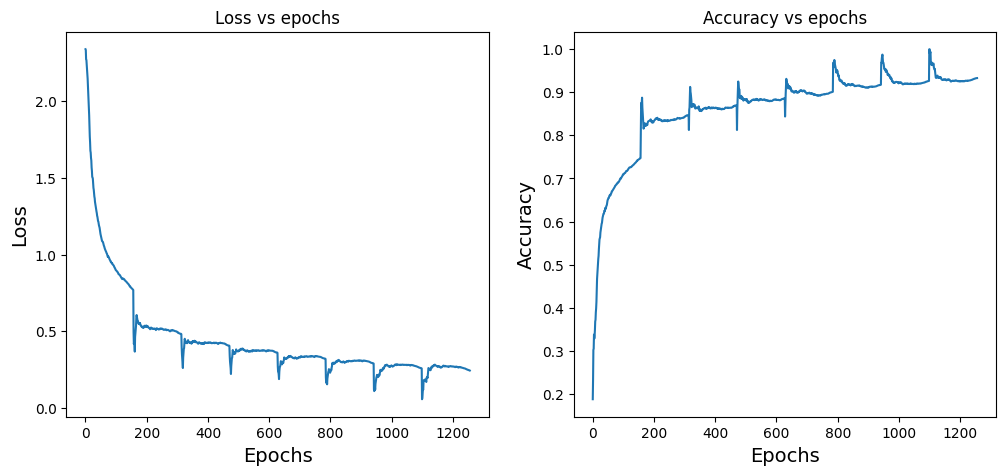

In [15]:
fig, axes = plt.subplots(1, 2, sharex=True, figsize=(12, 5))

axes[0].set_xlabel("Epochs", fontsize=14)
axes[0].set_ylabel("Loss", fontsize=14)
axes[0].set_title('Loss vs epochs')
axes[0].plot(train_loss_results)

axes[1].set_title('Accuracy vs epochs')
axes[1].set_ylabel("Accuracy", fontsize=14)
axes[1].set_xlabel("Epochs", fontsize=14)
axes[1].plot(train_accuracy_results)
plt.show()

#### Evaluate the model performance on the test dataset

In [16]:
# Compute the test loss and accuracy

epoch_loss_avg = tf.keras.metrics.Mean()
epoch_accuracy = tf.keras.metrics.CategoricalAccuracy()

for x, y in test_dataset:
    model_output = resnet_model(x)
    epoch_loss_avg(loss_obj(y, model_output))
    epoch_accuracy(to_categorical(y), model_output)

print("Test loss: {:.3f}".format(epoch_loss_avg.result().numpy()))
print("Test accuracy: {:.3%}".format(epoch_accuracy.result().numpy()))

Test loss: 0.585
Test accuracy: 84.250%


#### Model predictions

Let's see some model predictions! We will randomly select four images from the test data, and display the image and label for each.

For each test image, model's prediction (the label with maximum probability) is shown, together with a plot showing the model's categorical distribution.

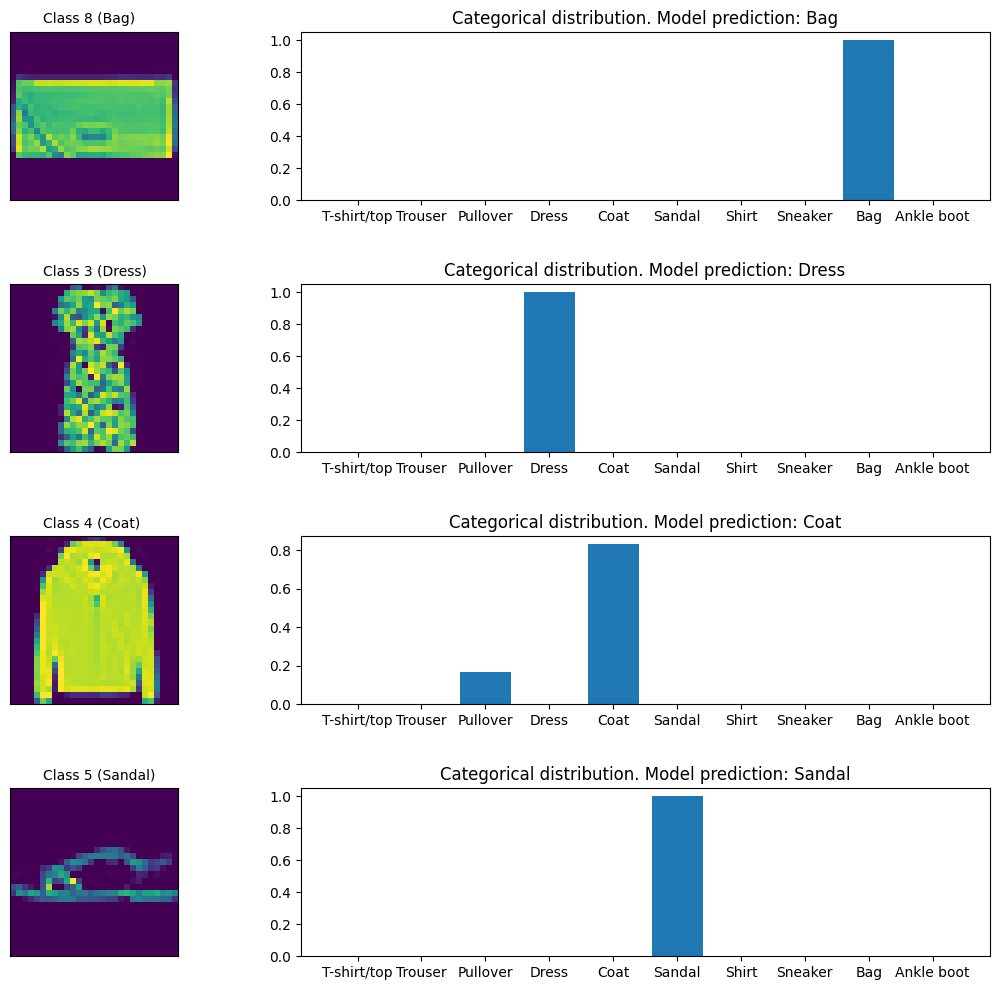

In [17]:
# Run this cell to get model predictions on randomly selected test images

num_test_images = test_images.shape[0]

random_inx = np.random.choice(test_images.shape[0], 4)
random_test_images = test_images[random_inx, ...]
random_test_labels = test_labels[random_inx, ...]

predictions = resnet_model(random_test_images)

fig, axes = plt.subplots(4, 2, figsize=(16, 12))
fig.subplots_adjust(hspace=0.5, wspace=-0.2)

for i, (prediction, image, label) in enumerate(zip(predictions, random_test_images, random_test_labels)):
    axes[i, 0].imshow(np.squeeze(image))
    axes[i, 0].get_xaxis().set_visible(False)
    axes[i, 0].get_yaxis().set_visible(False)
    axes[i, 0].text(5., -2., f'Class {label} ({image_labels[label]})')
    axes[i, 1].bar(np.arange(len(prediction)), prediction)
    axes[i, 1].set_xticks(np.arange(len(prediction)))
    axes[i, 1].set_xticklabels(image_labels, rotation=0)
    pred_inx = np.argmax(prediction)
    axes[i, 1].set_title(f"Categorical distribution. Model prediction: {image_labels[pred_inx]}")

plt.show()

Congratulations for completing this programming assignment! You're now ready to move on to the capstone project for this course.